In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

モデルが複雑であるほど過剰適合の危険性が高まる。反対にモデルがシンプルであるほど、頑健で汎化性能が高くなる。有用な特徴量だけ残してデータの次元数を減らすことは良いアプローチである。どうしたらよい特徴量がわかるだろうか？3つの方法で検証していく。

# 単変量統計
単変量統計では個々の特徴量とターゲットとの間に統計的に顕著な関係があるかどうかを検証する。そして最も高い確信度で関連している特徴量が選択される。クラス分類では分散分析(ANOVA)として知られる手法である。この方法の特性は単変量であることである。つまり個々の特徴量を個別に考慮するので、ほかの特徴量と組み合わさって意味をもつような特徴量は切り捨てられてしまう。  
p-値が大きすぎる(つまり、特定的に有意ではない)特徴量を捨てる。この捨てる際のスレッショルド(=閾値)を決めるが、一般的なのは数をしているする方法と、特徴量の数の割合を指定する二つの方法がある

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

#シード固定で乱数を決定
rng = np.random.RandomState(42)
#ノイズデータをデータセットに加える
#最初の30はデータセットからきたものであり、のこり50はノイズである
noise = rng.normal(size=(len(cancer.data), 50))
X_w_noise = np.hstack([cancer.data, noise]) 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=.5)
#クラス分類なのでテスト方法はf_classif(デフォルト)で残す特徴量を50パーセント選択
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [13]:
print('X_train shape: {}'.format(X_train.shape))
print('X_train_selected shape: {}'.format(X_train_selected.shape))

X_train shape: (284, 80)
X_train_selected shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Sample index')

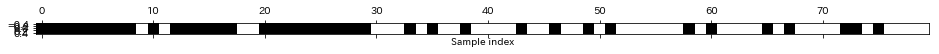

In [17]:
mask = select.get_support()
print(mask)
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Sample index')

特徴量の数が80から40に変わっており、ほとんどのノイズが取り除かれていることがわかる。しかし、もとの特徴量の回復は完全ではない。

In [18]:
from sklearn.linear_model import LogisticRegression

X_test_slected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Score with all features: {:,.3f}'.format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print('Score with all features: {:,.3f}'.format(lr.score(X_test_slected, y_test)))

Score with all features: 0.930
Score with all features: 0.940


/Users/ktr.w/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


今回の場合は、ノイズを取り除いたことで元の特徴量が失われてしまったのにも関わらず、特徴量を選択した方が性能がいいことがわかる。  
これがいつも有用であるとは限らないが、それでも特徴量が多すぎる場合や、多くの特徴量が関係ないと思われる場合には有用である。

# モデルベース特徴量選択
教師あり学習モデルを用いて個々の特徴量の重要性を判断して重要なものだけを残す手法。特徴量選択に用いる教師あり学習モデルは最終的に使う教師あり学習と同じである必要はない。

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)

SelectFromModelは教師あり学習モデルで用いられた特徴量の重要性が、指定したスレッショルドよりも大きい特徴量だけを選択する。  
今回の例では50パーセントだけを残す。教師あり学習モデルは決定木モデルで、これは交互作用を捉えることができるモデルだし、単変量テストより複雑なのではるかに強力な手法である。

In [29]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print('X_train.shape: {}'.format(X_train.shape))
print('X_train_l1.shape: {}'.format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


Text(0.5,0,'Sample index')

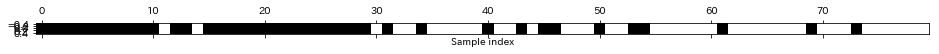

In [30]:
mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Sample index')

もとの特徴量2つをのぞいてすべて選択されている。性能差を比較してみる

In [33]:
X_test_l1 = select.transform(X_test)
print('Test score without feature select :{:,.3f}'.format(LogisticRegression().fit(X_train,y_train).score(X_test, y_test)))
print('Test score with feature select :{:,.3f}'.format(LogisticRegression().fit(X_train_l1,y_train).score(X_test_l1, y_test)))

Test score without feature select :0.930
Test score with feature select :0.951


性能が向上していることがわかる。ちなみに決定木モデルでも汎化性能の上昇がみられた

In [34]:
X_test_l1 = select.transform(X_test)
print('Test score without feature select :{:,.3f}'.format(RandomForestClassifier().fit(X_train,y_train).score(X_test, y_test)))
print('Test score with feature select :{:,.3f}'.format(RandomForestClassifier().fit(X_train_l1,y_train).score(X_test_l1, y_test)))

Test score without feature select :0.940
Test score with feature select :0.954


# 再帰的特徴量選択(RFE: Recursive Feature Elimination)
すべての特徴量からモデルを作り、そのモデルで最も重要度が低い特徴量を削除していき、決まった数になるまで削除を繰り返す手法である。  
これが機能するためにはモデルが特徴量の重要性を定量的に評価する方法を備えていなければならない

Text(0.5,0,'Sample index')

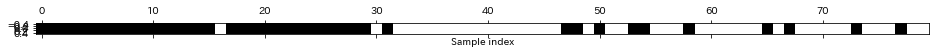

In [45]:
from sklearn.feature_selection import RFE

select = RFE(
    RandomForestClassifier(n_estimators=100, random_state=42),
    n_features_to_select=40
)

select.fit(X_train, y_train)

mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Sample index')

単変量テストやモデルベース特徴量選択と比較して、特徴量の選択は良くなっている(もとの特徴量をひとつ落としているだけ)。  

In [48]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

print('Test score without feature select :{:,.3f}'.format(LogisticRegression().fit(X_train,y_train).score(X_test, y_test)))
print('Test score with feature select :{:,.3f}'.format(LogisticRegression().fit(X_train_rfe,y_train).score(X_test_rfe, y_test)))

Test score without feature select :0.930
Test score with feature select :0.951


In [50]:
#RFE内部で用いられたモデルを使うこともできる
print('Test score :{:,.3f}'.format(select.score(X_test, y_test)))

Test score :0.951


RFE内部で用いられたランダムフォレストの性能は選択された特徴量で訓練したロジスティック回帰モデルと同じである。つまり適切な特徴量を選んだところで、線形モデルの性能がランダムフォレストと同じになったということである。

# まとめ
**実世界のデータでは、特徴量の選択で性能が大幅に向上することはあまりない。**しかし、予測を高速にしたい場合や明らかに不要な特徴量が含まれている場合、そしてなにより**解釈しやすいモデルを構築したい場合**には特徴量選択は備えておくべきツールボックスであることは間違いない。